## TZ Survey Analysis

In [ ]:
# import necessary libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import modin.pandas as pd

In [ ]:
# The first step is to fetch all the data
# determine the relative path of the folder holding the csv files
folder_path = "./TZA_2020_NPS-R5_v02_M_CSV"

In [ ]:
# Initialize an empty dictionary to store the data (household and consumption data specifically)
data_dict = {}

# Loop through each file in the folder
for filename in os.listdir(folder_path):
    if filename.startswith("hh_") or filename.startswith("consumption_"):
        # Create the variable name (removing the .csv extension)
        var_name = os.path.splitext(filename)[0]
        
        # Construct the full file path
        file_path = os.path.join(folder_path, filename)
        
        # Read the CSV file into a DataFrame
        data_dict[var_name] = pd.read_csv(file_path)

In [ ]:
# List of all datasets:
data_dict.keys()

From the review of the data, it seems like the important datasets are:
1. hh_sec_a {y5_hhid}
2. hh_sec_b {y5_hhid, indidy5}
3. hh_sec_e2 (occupation data) {y5_hhid, indidy5}
3. hh_sec_e3 (firewood collection shows source of energy) {y5_hhid, indidy5}
4. hh_seg_g (financial status) {y5_hhid, indidy5}
5. hh_sec_j1 (food consumed) {y5_hhid, itemcode
6. hh_sec_m (household assets) {y5_hhid, itemcode}

# Columns of interest

In [ ]:
a_hh_basic = data_dict['hh_sec_a'][['y5_hhid','y5_rural','hh_a02_1',]].rename(columns = {'hh_a02_1':'location'})
a_hh_basic

In [ ]:
# getting region and district info from the location column "hh_a02_1"
a_hh_basic['location'] = a_hh_basic['location'].astype(str)

# extract all but the last xter
a_hh_basic['region'] = a_hh_basic['location'].str[:-1]
# extract the last xter
a_hh_basic['district'] = a_hh_basic['location'].str[-1]

# convert region/district back into integers
a_hh_basic['region'] = a_hh_basic['region'].astype(int)
a_hh_basic['district'] = a_hh_basic['district'].astype(int)
a_hh_basic = a_hh_basic.drop(columns = ['location'])

In [116]:
# [OBS] region data does not align perfectly with "MAGERESHO YA MIKOA NA WILAYA" section
# of the questionairre
a_hh_basic.groupby(['region', 'district']).size().reset_index(name='count')

,region,district,count
0,1,1,13
1,1,2,13
2,1,3,10
3,1,4,8
4,1,5,168
...,...,...,...
182,53,2,51
183,54,1,41
184,54,2,52
185,55,1,49


In [117]:
a_hh_basic

,y5_hhid,y5_rural,region,district
0,1000-001-01,1,2,2
1,1000-001-02,1,2,2
2,1000-001-03,1,2,2
3,1000-001-06,1,2,2
4,1001-001-01,1,2,2
...,...,...,...,...
4704,9807-001-99,2,19,3
4705,9808-001-99,2,19,3
4706,9809-001-99,2,19,3
4707,9810-001-99,2,19,3


In [118]:

data_dict['hh_sec_c']

,interview__key,y5_hhid,indidy5,hh_c01,hh_c01_1,hh_c01_2,hh_c02,hh_c03,hh_c03_1,hh_c04,...,hh_c28_2,hh_c28_3,hh_c28_4,hh_c28_5,hh_c28_6,hh_c28_7,hh_c28_8,hh_c29,hh_c30,hh_c01_3
0,39-26-37-98,1000-001-01,1,1.0,1.0,NaN,1.0,1.0,NaN,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,1.0
1,39-26-37-98,1000-001-01,3,1.0,1.0,NaN,1.0,1.0,NaN,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,1.0
2,39-26-37-98,1000-001-01,5,1.0,2.0,3.0,1.0,1.0,NaN,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN
3,39-26-37-98,1000-001-01,7,1.0,2.0,3.0,1.0,1.0,NaN,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,30000.0,NaN,NaN,NaN
4,04-06-65-04,1000-001-02,1,1.0,1.0,NaN,1.0,1.0,NaN,13.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23587,53-69-11-30,9811-001-99,1,1.0,1.0,NaN,1.0,1.0,NaN,9.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,1.0
23588,53-69-11-30,9811-001-99,2,1.0,1.0,NaN,3.0,1.0,NaN,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,1.0
23589,53-69-11-30,9811-001-99,3,1.0,2.0,2.0,1.0,1.0,NaN,7.0,...,50000.0,43000.0,0.0,60000.0,10000.0,24000.0,NaN,NaN,NaN,NaN
23590,53-69-11-30,9811-001-99,4,1.0,2.0,2.0,5.0,2.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [119]:
data_dict.keys()

dict_keys(['hh_sec_q1', 'hh_sec_q2', 'hh_sec_e3', 'hh_sec_e2', 'hh_sec_e1', 'hh_sec_i2', 'hh_sec_a', 'hh_sec_v', 'hh_sec_c', 'hh_sec_b', 'hh_sec_ja1', 'hh_sec_f', 'hh_sec_p', 'hh_sec_g', 'hh_sec_o2', 'hh_sec_r', 'hh_sec_s', 'hh_sec_d', 'hh_sec_o1', 'hh_sec_u2', 'hh_sec_i', 'hh_sec_h', 'hh_sec_k', 'consumption_real_y5', 'consumption_real_y4', 'hh_sec_n', 'hh_sec_l', 'hh_sec_m', 'hh_sec_j3', 'hh_sec_j1', 'hh_sec_j4'])

In [120]:
# Consumption data: Construction from nps_wave_5_report.pdf, appendix A.
# consumption is for 28 days
# data dictionaty: https://microdata.worldbank.org/index.php/catalog/5639/data-dictionary/F65?file_name=consumption_real_y5

data_dict['consumption_real_y5']#.columns

# 2021 Exchange rate (USD): 0.0004
# https://www.exchangerates.org.uk/TZS-USD-spot-exchange-rates-history-2021.html

,y5_hhid,booster,cluster,strata,hhweight2,urban,area,region,district,month,...,nf_clothingR_pae,nf_utilitiesR_pae,nf_hhexpensesR_pae,nf_transportR_pae,nf_communicR_pae,nf_recreatR_pae,nf_otherR_pae,dur_expR_pae,rent_expR_pae,expmR_pae
0,1230-001-01,0,70116204544,1,783.868164,2,1,7,71,1,...,0.000000,189222.421875,0.000000,1199.313232,3459.557373,0.0,4804.940918,7020.397949,21496.183594,400203.750000
1,1210-001-01,0,70114197504,1,7803.531738,2,1,7,71,2,...,8342.855469,8920.335938,0.000000,0.000000,2395.078369,0.0,4071.633057,5589.160156,18357.865234,162522.250000
2,1249-001-01,0,70119202816,1,3071.586182,2,1,7,71,2,...,5631.837891,16171.419922,362.046722,37652.859375,7240.934082,0.0,6275.476562,2994.131104,16895.513672,193675.281250
3,1253-001-01,0,70119202816,1,2179.735840,2,1,7,72,2,...,8320.455078,9047.399414,262.751190,6831.531250,1313.755981,0.0,11736.220703,480.378845,7882.536133,109706.046875
4,1291-001-01,0,70123208704,1,1843.329712,2,1,7,71,3,...,5264.543945,16828.490234,1835.069580,6257.286621,4512.466309,0.0,5866.206055,10374.131836,29132.677734,211980.781250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4704,3300-001-01,0,530103304192,4,75.445923,2,4,53,531,11,...,6609.943848,20378.623047,4665.842773,13330.978516,1999.646851,0.0,1932.991943,12790.872070,7005.061523,156576.218750
4705,3572-001-03,0,530224218112,4,546.535278,2,4,53,531,12,...,2690.599365,15103.634766,0.000000,5030.514160,2176.664795,0.0,5260.272949,3312.602295,22306.177734,137469.125000
4706,2387-001-01,0,510116200448,4,141.791733,2,4,51,511,10,...,2229.154541,3753.085693,0.000000,0.000000,972.721985,0.0,1580.673218,1163.224487,8576.289062,95926.726562
4707,3321-001-06,0,530116313088,4,241.140274,2,4,53,531,12,...,4400.737793,33697.078125,2095.589355,5230.591309,4023.531738,0.0,2766.178223,5293.585938,40235.316406,274493.000000


In [ ]:
data_dict['hh_sec_i']

#### Energy Data

In [121]:
i_hh_energy = data_dict['hh_sec_i'][['y5_hhid','hh_i16','hh_i16_1','hh_i17','hh_i18']].rename(columns = {
    'hh_i16':'cooking_fuel',
    'hh_i16_1':'cooking_stove',
    'hh_i17':'lighting_fuel',
    'hh_i18':'electricity_source'
})

In [123]:
# Create dictionaries to help in renaming the values in the columns
# Fuel used for cooking
ckfuel_dict = { 1:'Firewood',
                2:'Paraffin',
                3:'Electricity',
                4:'Gas',
                5:'Charcoal',
                6:'Animal Residue',
                7:'Gas (Biogas)'}

# Assumptions made in assigning the codes to the stove types, since the questionnaire only has 2 codes while the data has 4 outcomes
stove_dict = {  1:'stone',
                2:'other self-built',
                3:'manufactured',
                4:'other'}

light_dict = {  1:'Electricity',
                2:'Solar',
                3:'Gas',
                4:'Gas (Biogas)',
                5:'Lamp oil',
                6:'Candle',
                7:'Firewood',
                8:'Private Generator',
                9:'Torch',
                10:'Other'}

elec_dict = {   1:'Tanesco',
                2:'Community Generator',
                3:'Solar Panels',
                4:'Own Generator',
                5:'Car Battery',
                6:'Motorcycle Battery',
                7:'Other'}

In [124]:
#df['string_column'] = df['code_column'].map(code_to_string)
i_hh_energy['cooking_fuel'] = i_hh_energy['cooking_fuel'].map(ckfuel_dict)
i_hh_energy['cooking_stove'] = i_hh_energy['cooking_stove'].map(stove_dict)
i_hh_energy['lighting_fuel'] = i_hh_energy['lighting_fuel'].map(light_dict)
i_hh_energy['electricity_source'] = i_hh_energy['electricity_source'].map(elec_dict)
i_hh_energy

,y5_hhid,cooking_fuel,cooking_stove,lighting_fuel,electricity_source
0,1000-001-01,Firewood,stone,Solar,Solar Panels
1,1000-001-02,Charcoal,manufactured,Candle,NaN
2,1000-001-03,Firewood,stone,Solar,Solar Panels
3,1000-001-06,Firewood,stone,Electricity,Tanesco
4,1001-001-01,Firewood,stone,Solar,Community Generator
...,...,...,...,...,...
4704,9807-001-99,Electricity,NaN,Electricity,Tanesco
4705,9808-001-99,Electricity,NaN,Electricity,Tanesco
4706,9809-001-99,Firewood,stone,Lamp oil,NaN
4707,9810-001-99,Charcoal,manufactured,Solar,Solar Panels


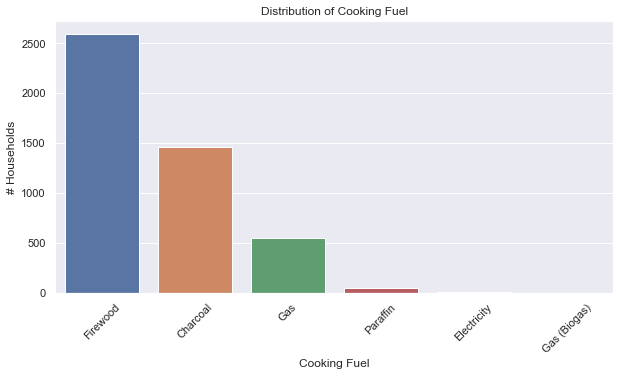

In [125]:
# Households using certain fuel types
cooking_fuel_counts = i_hh_energy['cooking_fuel'].value_counts()
lighting_fuel_counts = i_hh_energy['lighting_fuel'].value_counts()
electricity_source_counts = i_hh_energy['electricity_source'].value_counts()

# Plot the distribution of cooking fuel
plt.figure(figsize=(10, 5))
sns.barplot(x=cooking_fuel_counts.index, y=cooking_fuel_counts.values)
plt.title('Distribution of Cooking Fuel')
plt.xticks(rotation=45)
plt.xlabel('Cooking Fuel')
plt.ylabel('# Households')
plt.show()

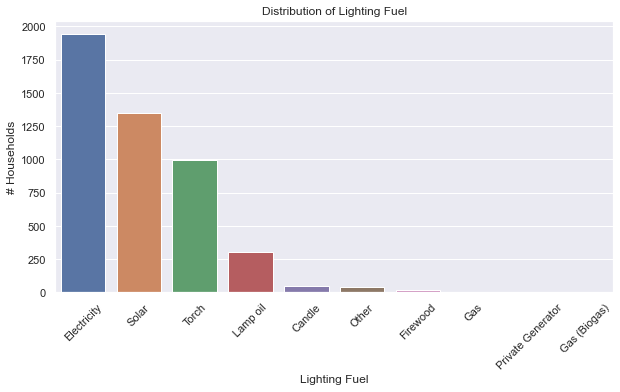

In [126]:
# Plot the distribution of Lighting fuel
plt.figure(figsize=(10, 5))
sns.barplot(x=lighting_fuel_counts.index, y=lighting_fuel_counts.values)
plt.title('Distribution of Lighting Fuel')
plt.xticks(rotation=45)
plt.xlabel('Lighting Fuel')
plt.ylabel('# Households')
plt.show()

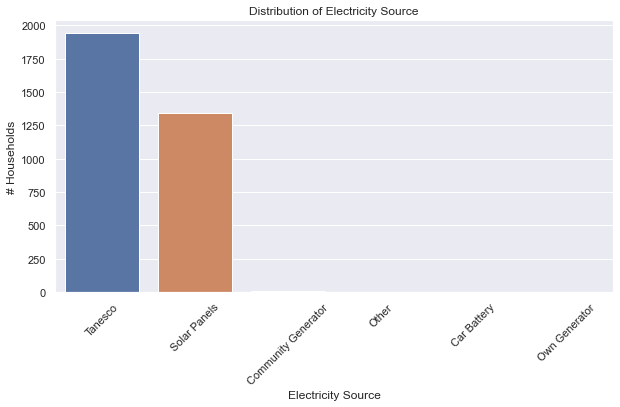

In [127]:
# Plot the distribution of cooking fuel
plt.figure(figsize=(10, 5))
sns.barplot(x=electricity_source_counts.index, y=electricity_source_counts.values)
plt.title('Distribution of Electricity Source')
plt.xticks(rotation=45)
plt.xlabel('Electricity Source')
plt.ylabel('# Households')
plt.show()

In [129]:
# Create a cross-tabulation between electricity source and cooking fuel
electricity_cooking_cross = pd.crosstab(i_hh_energy['electricity_source'], i_hh_energy['cooking_fuel'])

# Create a cross-tabulation between electricity source and lighting fuel
electricity_lighting_cross = pd.crosstab(i_hh_energy['electricity_source'], i_hh_energy['lighting_fuel'])

# Print the cross-tabulations
print("Cross-tabulation between Electricity Source and Cooking Fuel:")
print(electricity_cooking_cross)
print("\nCross-tabulation between Electricity Source and Lighting Fuel:")
print(electricity_lighting_cross)


Cross-tabulation between Electricity Source and Cooking Fuel:
cooking_fuel         Charcoal  Electricity  Firewood  Gas  Gas (Biogas)  \
electricity_source                                                        
Car Battery                 1            0         1    0             0   
Community Generator         1            0        10    1             0   
Other                       2            0         0    0             0   
Own Generator               0            0         1    0             0   
Solar Panels              267            1      1037   25             0   
Tanesco                   981           11       392  501             1   

cooking_fuel         Paraffin  
electricity_source             
Car Battery                 0  
Community Generator         0  
Other                       0  
Own Generator               0  
Solar Panels                5  
Tanesco                    34  

Cross-tabulation between Electricity Source and Lighting Fuel:
lighting_fuel    

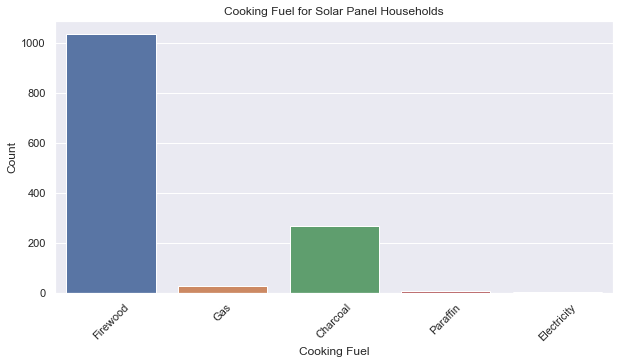

In [131]:
sns.set()
plt.figure(figsize=(10, 5))
sns.countplot(data=i_hh_energy[i_hh_energy['electricity_source'] == 'Solar Panels'], x='cooking_fuel')
plt.title('Cooking Fuel for Solar Panel Households')
plt.xlabel('Cooking Fuel')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

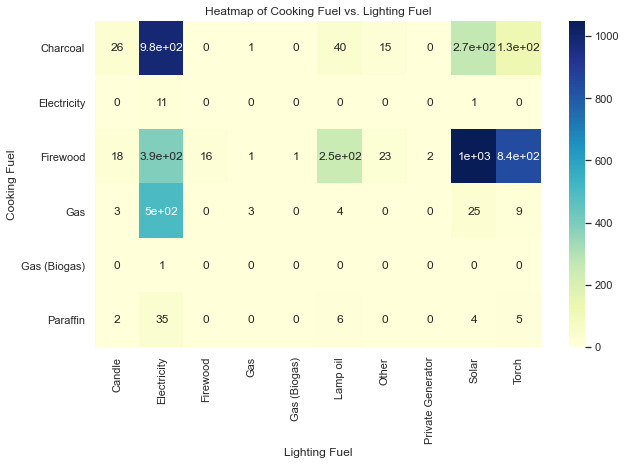

In [132]:
crosstab = pd.crosstab(i_hh_energy['cooking_fuel'], i_hh_energy['lighting_fuel'])

# Create a heatmap to visualize relationships
plt.figure(figsize=(10, 6))
sns.heatmap(crosstab, annot=True, cmap='YlGnBu')
plt.title('Heatmap of Cooking Fuel vs. Lighting Fuel')
plt.xlabel('Lighting Fuel')
plt.ylabel('Cooking Fuel')
plt.show()

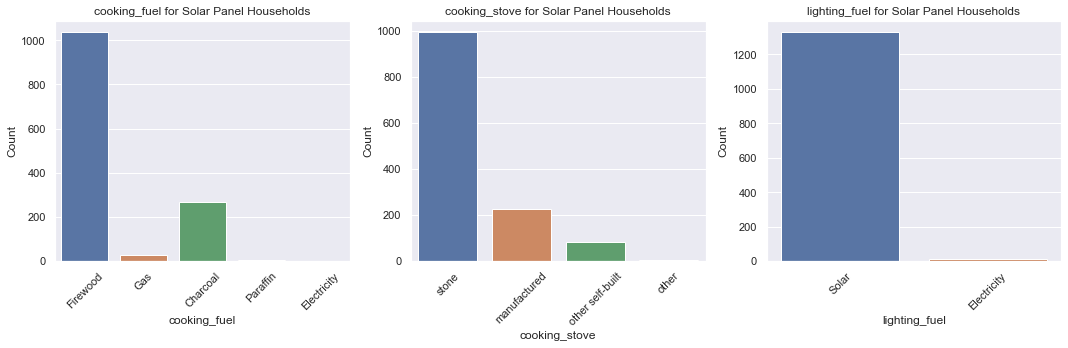

In [133]:
fig, axes = plt.subplots(1, len(columns_of_interest), figsize=(15, 5))

for i, col in enumerate(columns_of_interest):
    sns.countplot(data=i_hh_energy[i_hh_energy['electricity_source'] == 'Solar Panels'], x=col, ax=axes[i])
    axes[i].set_title(f'{col} for Solar Panel Households')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()